In [1]:
import os
import requests
import scipy
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def Tscore(df, experimentalcols, controlcols, output_subfolder):
    dfstat = pd.DataFrame()
    dfpval = pd.DataFrame()
    tempnum = 0
    row_header = df.iloc[:, 0]
    midpt = int((len(df.index)) / 2)
    for r in df.iterrows():
        row = r[1]
        controlvals = []
        experimentalvals = []
        for iter in controlcols:
            controlvals.append(row[iter])
        for iter in experimentalcols:
            experimentalvals.append(row[iter])

        stat, pval = scipy.stats.ttest_ind(experimentalvals[1:], controlvals[1:], equal_var=False)
        tempstatseries = pd.Series(stat)
        temppvalseries = pd.Series(pval)        
        dfstat = pd.concat([dfstat, tempstatseries])
        dfpval = pd.concat([dfpval, temppvalseries])

        if tempnum % 1000 == 0:
            print('T-scoring gene #' + str(tempnum))
        tempnum = tempnum + 1
       
    #calculate log10 of pvalues
    df2 = pd.concat([dfstat, dfpval], axis = 1)
    df2.columns = ['Tscore', 'pval']
    oldpval = df2['pval']  
    newpval = []
    for i in oldpval:
        tempnewpval = np.log10(i)
        tempnewpval = tempnewpval * (-1)
        newpval.append(float(tempnewpval))
    df2['log10pval'] = newpval
    dfstat = df2['log10pval']
    
    #save gene signature data
    df2.set_index(row_header, inplace=True)
    save_loc = output_subfolder + "\Tscoredata.txt"
    df2.to_csv(save_loc, sep='\t', index=True)
    print('Tscore done')
    print()
    return dfstat

In [3]:
def FCstat(df, experimentalcols, controlcols, output_subfolder):
    dfFC = pd.DataFrame()
    tempnum = 0
    row_header = df.iloc[:, 0]
    for r in df.iterrows():
        geneID = r[0]
        row = r[1]
        controlvals = []
        experimentalvals = []
        for iter in controlcols:
            controlvals.append(row[iter])
        for iter in experimentalcols:
            experimentalvals.append(row[iter])
        
        m1 = np.mean(experimentalvals[1:])
        m2 = np.mean(controlvals[1:])
        FC = m1 - m2
        tempFC = pd.Series(FC, name = geneID)        
        dfFC = pd.concat([dfFC, tempFC])

        if tempnum % 1000 == 0:
            print('FC of gene #' + str(tempnum))
        tempnum = tempnum + 1
    dfFC = dfFC.reset_index(drop=True)    

    #save gene signature data    
    dfFC2 = dfFC
    dfFC2.set_index(row_header, inplace=True)
    save_loc = output_subfolder + "\FCdata.txt"
    dfFC2.to_csv(save_loc, sep='\t', index=True, header=False) #change file name as needed
    print('FC done')
    print()
    return dfFC

In [4]:
def volcano_plot(df, log10pvaldf, dfFC, output_subfolder):
    besthighFClist = []
    bestlowFClist = []
    normalFClist = []
    besthighpvallist = []
    bestlowpvallist = []
    normalpvallist = []
    besthighpos = []
    bestlowpos = []

    pnotFCFClist = []
    pnotFCpvallist = []
    FCnotpFClist = []
    FCnotppvallist = []

    tempFCarray = dfFC[0]
    tempnum = 0

    for i in log10pvaldf:
        i2 = tempFCarray[tempnum]
        if i > 1: #p<0.05
            if i2 > 1: #FC for top genes
                besthighFClist.append(i2)
                besthighpvallist.append(i)
                besthighpos.append(tempnum)
            elif i2 < -1: #FC for bottom genes
                bestlowFClist.append(i2)
                bestlowpvallist.append(i)
                bestlowpos.append(tempnum)
            else:
                pnotFCFClist.append(i2)
                pnotFCpvallist.append(i)
        else:
            if i2 > 1 or i2 < -1: #FC of 2 for top and bottom genes
                FCnotpFClist.append(i2)
                FCnotppvallist.append(i)
            else:
                normalFClist.append(i2)
                normalpvallist.append(i)
        tempnum = tempnum + 1

    top = []
    for i in besthighpos:
        r = df.iloc[[i]]
        geneID = list(r.iloc[:, 0])
        top.append(geneID)

    bottom = []
    for i in bestlowpos:
        r = df.iloc[[i]]
        geneID = list(r.iloc[:, 0])
        bottom.append(geneID)

    print('There are', (len(top)) , 'top items:')
    print()
    top_df = pd.DataFrame(top, columns=["Positive Genes"])
    temp_file_name = output_subfolder + "\\positive_genes.csv"
    top_df.to_csv(temp_file_name, index=False)

    print('There are', (len(bottom)) , 'bottom items:')
    bottom_df = pd.DataFrame(bottom, columns=["Negative Genes"])
    temp_file_name = output_subfolder + "\\negative_genes.csv"
    bottom_df.to_csv(temp_file_name, index=False)

    #plot results
    plt.figure(figsize=(10, 10))
    plt.scatter(besthighFClist, besthighpvallist, label = 'p-value and log2FC', color = 'red', marker = 'p')
    plt.scatter(bestlowFClist, bestlowpvallist, color = 'red', marker = 'p')
    plt.scatter(FCnotpFClist, FCnotppvallist, label = 'log2FC', color = 'green', marker = 's')
    plt.scatter(pnotFCFClist, pnotFCpvallist, label = 'p-value', color = 'blue', marker = 'x')
    plt.scatter(normalFClist, normalpvallist, label = 'not significant', color = 'black', marker = 'o')
    plt.axhline(y=1, color='navy', linestyle='--', label = 'cut-off')
    plt.axvline(x=1, color='navy', linestyle='--')
    plt.axvline(x=-1, color='navy', linestyle='--')
    plt.title("Volcano plot")
    plt.xlabel("log2(fold change)")
    plt.ylabel("-log10(p-value)")
    plt.legend(loc='best')
    save_loc = output_subfolder + "\\volcanoplotfig.png"
    plt.savefig(save_loc, dpi=300)
    plt.show()

#### Main Program

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
cwd = os.getcwd()
input_folder = cwd + "\input" # Define the input folder containing the .txt files
output_folder = cwd + "\output" # Define the output folder
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

GSE11098
Experimental
Single knockout, biol rep 1 (430A)
Single knockout, biol rep 2 (430A)
Single knockout, biol rep 3 (430A)

Control
Normal, biol rep 1 (430A)
Normal, biol rep 2 (430A)
Normal, biol rep 3 (430A)
Normal, biol rep 4 (430A)

T-scoring gene #0
T-scoring gene #1000
T-scoring gene #2000
T-scoring gene #3000
T-scoring gene #4000
T-scoring gene #5000
T-scoring gene #6000
T-scoring gene #7000
T-scoring gene #8000
T-scoring gene #9000
T-scoring gene #10000
T-scoring gene #11000
T-scoring gene #12000
T-scoring gene #13000
Tscore done

FC of gene #0
FC of gene #1000
FC of gene #2000
FC of gene #3000
FC of gene #4000
FC of gene #5000
FC of gene #6000
FC of gene #7000
FC of gene #8000
FC of gene #9000
FC of gene #10000
FC of gene #11000
FC of gene #12000
FC of gene #13000
FC done

There are 2603 top items:

There are 1886 bottom items:


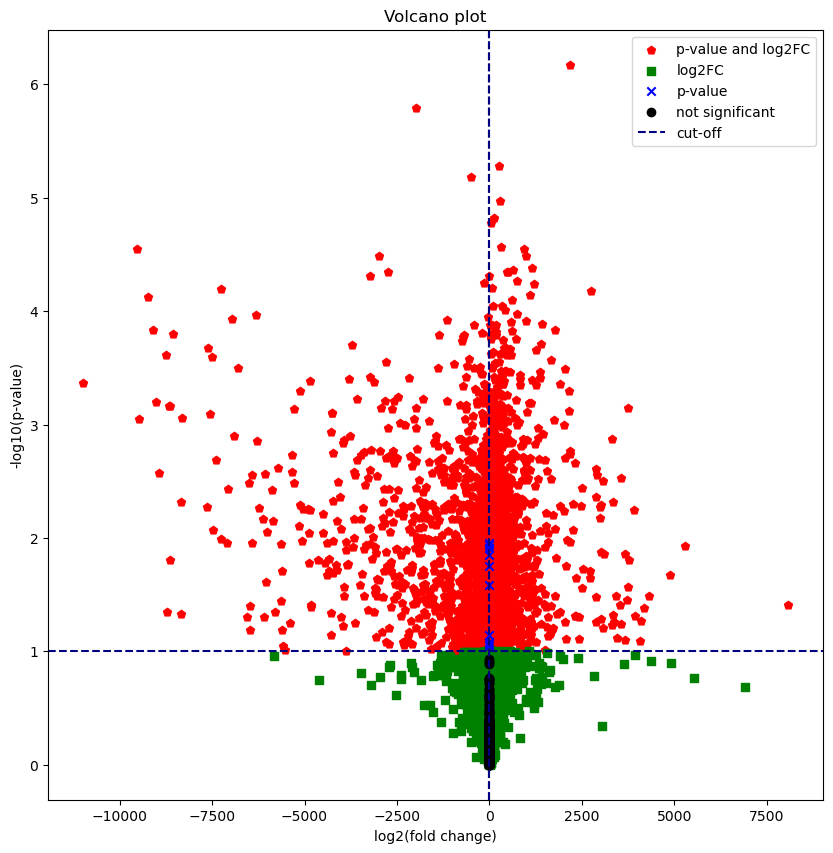

GSE156251
Experimental
GSM4727609r
GSM4727610r
GSM4727611r
GSM4727612r

Control
GSM4727609g
GSM4727610g
GSM4727611g
GSM4727612g

T-scoring gene #0
T-scoring gene #1000
T-scoring gene #2000
T-scoring gene #3000
T-scoring gene #4000
T-scoring gene #5000
T-scoring gene #6000
T-scoring gene #7000
T-scoring gene #8000
T-scoring gene #9000
T-scoring gene #10000
T-scoring gene #11000
T-scoring gene #12000
T-scoring gene #13000
T-scoring gene #14000
Tscore done

FC of gene #0
FC of gene #1000
FC of gene #2000
FC of gene #3000
FC of gene #4000
FC of gene #5000
FC of gene #6000
FC of gene #7000
FC of gene #8000
FC of gene #9000
FC of gene #10000
FC of gene #11000
FC of gene #12000
FC of gene #13000
FC of gene #14000
FC done

There are 4083 top items:

There are 3602 bottom items:


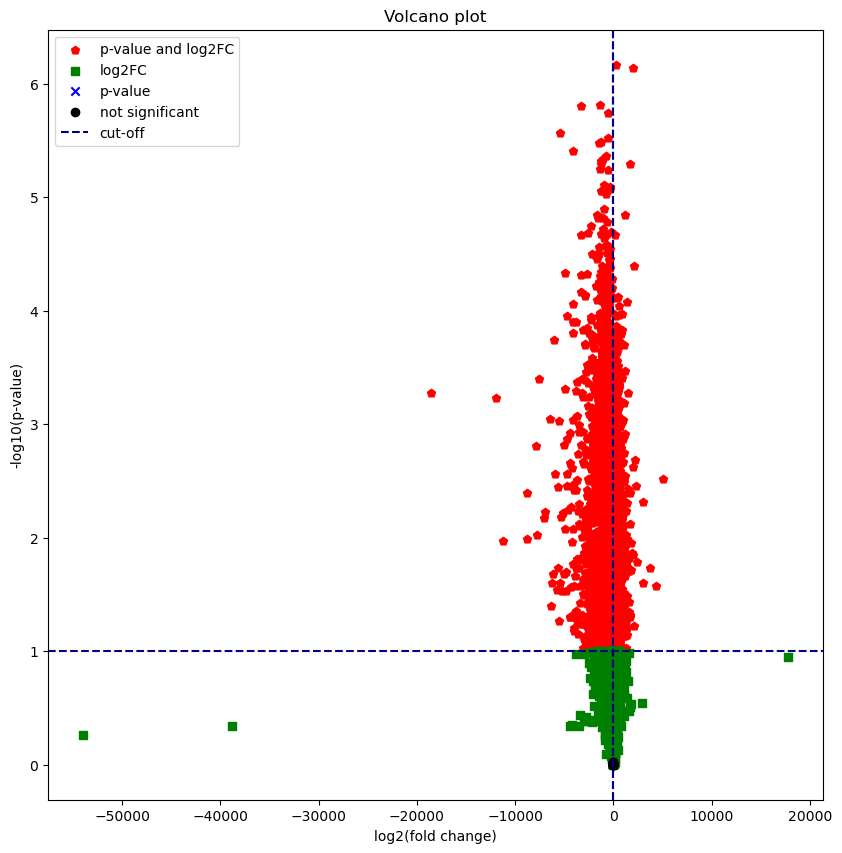

GSE156981
Experimental
GSM4749306r
GSM4749307r
GSM4749308r
GSM4749309r
GSM4749310r
GSM4749311r
GSM4749312r
GSM4749313r

Control
GSM4749306g
GSM4749307g
GSM4749308g
GSM4749309g
GSM4749310g
GSM4749311g
GSM4749312g
GSM4749313g

T-scoring gene #0
T-scoring gene #1000
T-scoring gene #2000
T-scoring gene #3000
T-scoring gene #4000
T-scoring gene #5000
T-scoring gene #6000
T-scoring gene #7000
T-scoring gene #8000
T-scoring gene #9000
T-scoring gene #10000
T-scoring gene #11000
T-scoring gene #12000
T-scoring gene #13000
T-scoring gene #14000
Tscore done

FC of gene #0
FC of gene #1000
FC of gene #2000
FC of gene #3000
FC of gene #4000
FC of gene #5000
FC of gene #6000
FC of gene #7000
FC of gene #8000
FC of gene #9000
FC of gene #10000
FC of gene #11000
FC of gene #12000
FC of gene #13000
FC of gene #14000
FC done

There are 8028 top items:

There are 4910 bottom items:


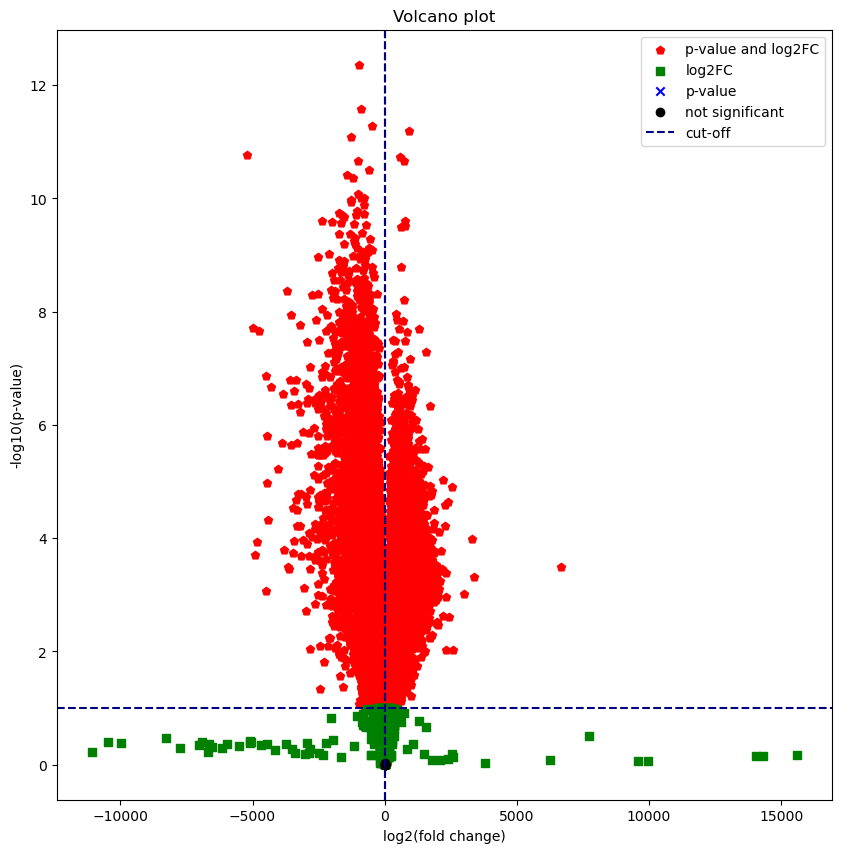

GSE161478FADverify
Experimental
FRG seven days withdrawal condition, biological rep1
FRG seven days withdrawal condition, biological rep2
FRG seven days withdrawal condition, biological rep3

Control
FRG control condition, biological rep1
FRG control condition, biological rep2
FRG control condition, biological rep3

T-scoring gene #0
T-scoring gene #1000
T-scoring gene #2000
T-scoring gene #3000
T-scoring gene #4000
T-scoring gene #5000
T-scoring gene #6000
T-scoring gene #7000
T-scoring gene #8000
T-scoring gene #9000
T-scoring gene #10000
T-scoring gene #11000
T-scoring gene #12000
T-scoring gene #13000
T-scoring gene #14000
T-scoring gene #15000
T-scoring gene #16000
T-scoring gene #17000
T-scoring gene #18000
T-scoring gene #19000
T-scoring gene #20000
T-scoring gene #21000
Tscore done

FC of gene #0
FC of gene #1000
FC of gene #2000
FC of gene #3000
FC of gene #4000
FC of gene #5000
FC of gene #6000
FC of gene #7000
FC of gene #8000
FC of gene #9000
FC of gene #10000
FC of gene #1

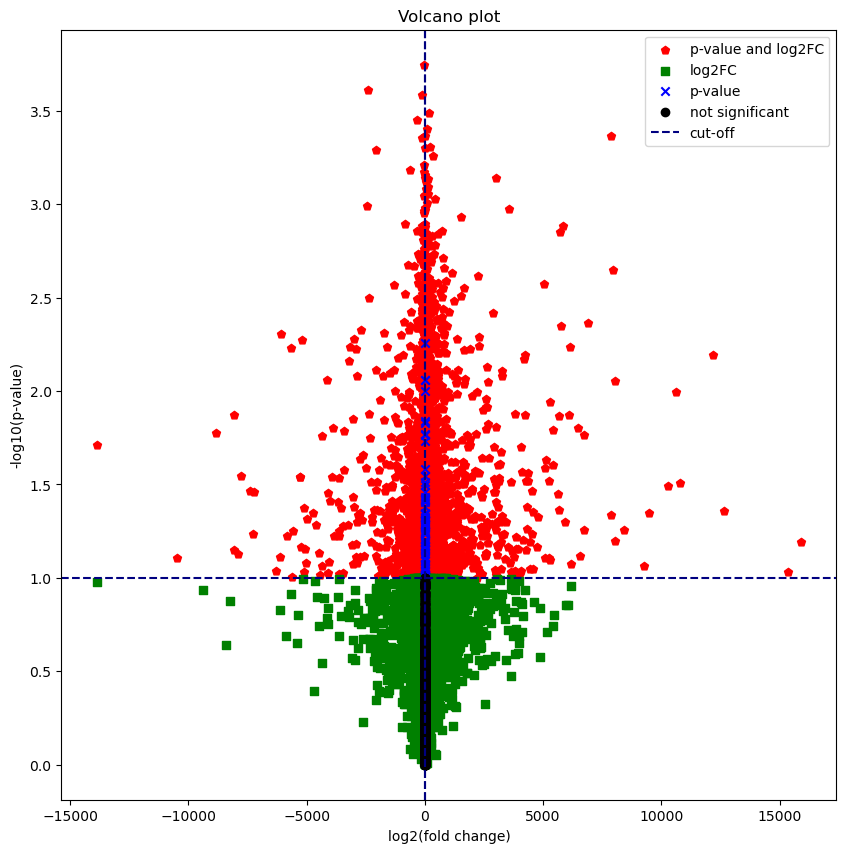

GSE205434FADID
Experimental
FAH seven days withdrawal condition, biological rep1
FAH seven days withdrawal condition, biological rep2
FAH seven days withdrawal condition, biological rep3

Control
FAH control condition, biological rep1
FAH control condition, biological rep2
FAH control condition, biological rep3

T-scoring gene #0
T-scoring gene #1000
T-scoring gene #2000
T-scoring gene #3000
T-scoring gene #4000
T-scoring gene #5000
T-scoring gene #6000
T-scoring gene #7000
T-scoring gene #8000
T-scoring gene #9000
T-scoring gene #10000
T-scoring gene #11000
T-scoring gene #12000
T-scoring gene #13000
T-scoring gene #14000
T-scoring gene #15000
T-scoring gene #16000
T-scoring gene #17000
T-scoring gene #18000
T-scoring gene #19000
T-scoring gene #20000
T-scoring gene #21000
T-scoring gene #22000
T-scoring gene #23000
T-scoring gene #24000
Tscore done

FC of gene #0
FC of gene #1000
FC of gene #2000
FC of gene #3000
FC of gene #4000
FC of gene #5000
FC of gene #6000
FC of gene #7000
FC 

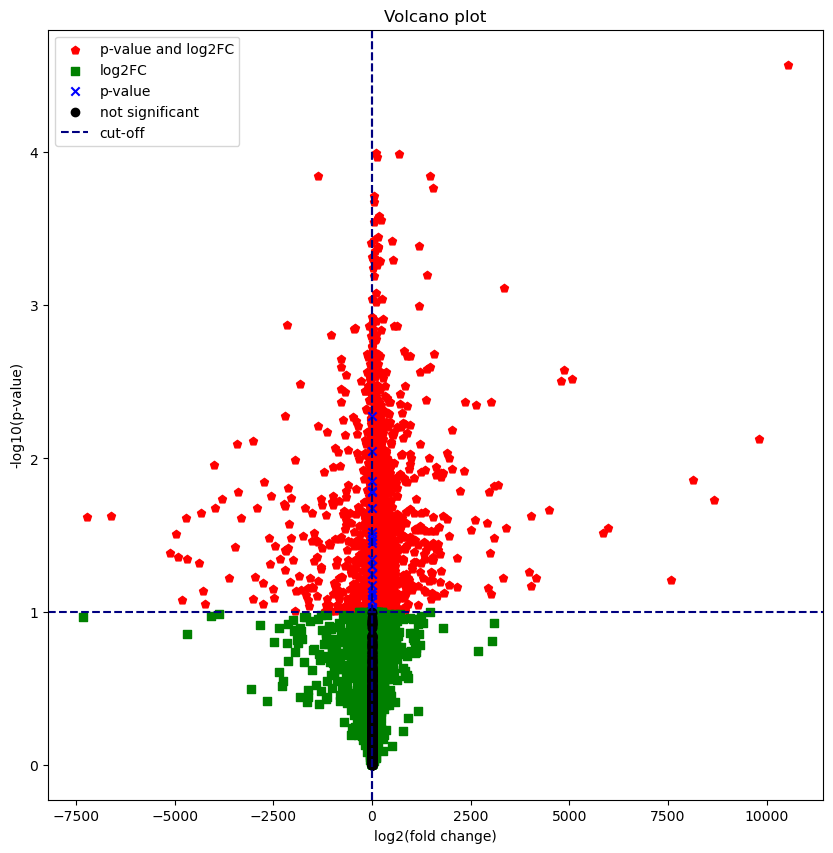

GSE225001AKU
Experimental
AKU seven days withdrawal condition, biological rep1
AKU seven days withdrawal condition, biological rep2
AKU seven days withdrawal condition, biological rep3

Control
AKU control condition, biological rep1
AKU control condition, biological rep2
AKU control condition, biological rep3

T-scoring gene #0
T-scoring gene #1000
T-scoring gene #2000
T-scoring gene #3000
T-scoring gene #4000
T-scoring gene #5000
T-scoring gene #6000
T-scoring gene #7000
T-scoring gene #8000
T-scoring gene #9000
T-scoring gene #10000
T-scoring gene #11000
T-scoring gene #12000
T-scoring gene #13000
T-scoring gene #14000
T-scoring gene #15000
T-scoring gene #16000
T-scoring gene #17000
T-scoring gene #18000
T-scoring gene #19000
T-scoring gene #20000
T-scoring gene #21000
T-scoring gene #22000
T-scoring gene #23000
T-scoring gene #24000
Tscore done

FC of gene #0
FC of gene #1000
FC of gene #2000
FC of gene #3000
FC of gene #4000
FC of gene #5000
FC of gene #6000
FC of gene #7000
FC of

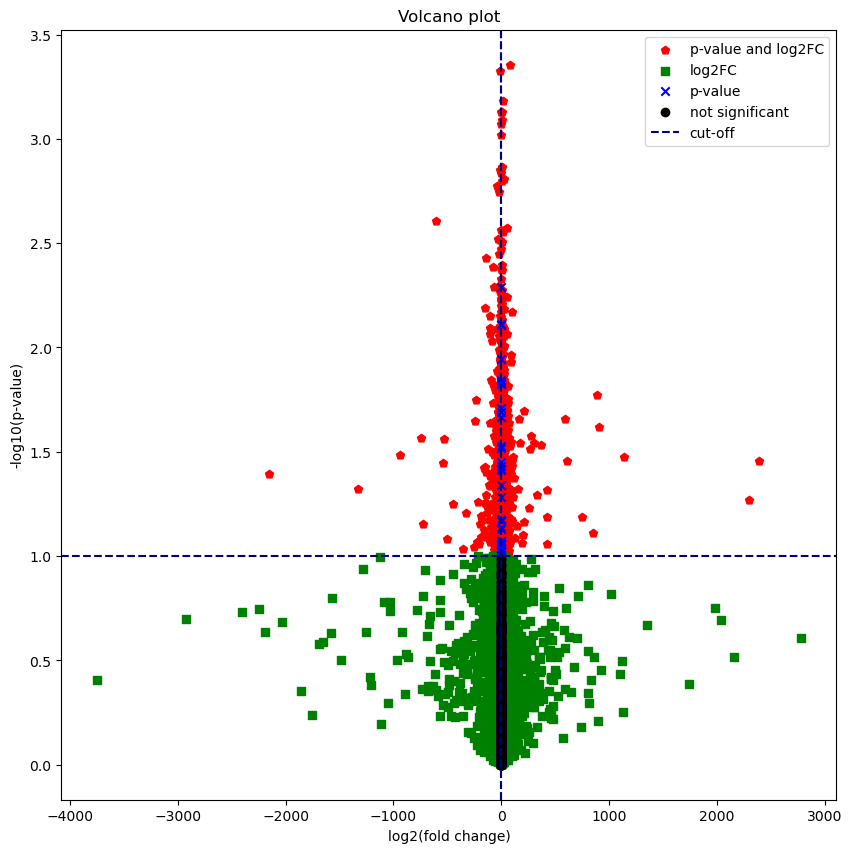

GSE225001FADID
Experimental
FAH seven days withdrawal condition, biological rep1
FAH seven days withdrawal condition, biological rep2
FAH seven days withdrawal condition, biological rep3

Control
FAH control condition, biological rep1
FAH control condition, biological rep2
FAH control condition, biological rep3

T-scoring gene #0
T-scoring gene #1000
T-scoring gene #2000
T-scoring gene #3000
T-scoring gene #4000
T-scoring gene #5000
T-scoring gene #6000
T-scoring gene #7000
T-scoring gene #8000
T-scoring gene #9000
T-scoring gene #10000
T-scoring gene #11000
T-scoring gene #12000
T-scoring gene #13000
T-scoring gene #14000
T-scoring gene #15000
T-scoring gene #16000
T-scoring gene #17000
T-scoring gene #18000
T-scoring gene #19000
T-scoring gene #20000
T-scoring gene #21000
T-scoring gene #22000
T-scoring gene #23000
T-scoring gene #24000
Tscore done

FC of gene #0
FC of gene #1000
FC of gene #2000
FC of gene #3000
FC of gene #4000
FC of gene #5000
FC of gene #6000
FC of gene #7000
FC 

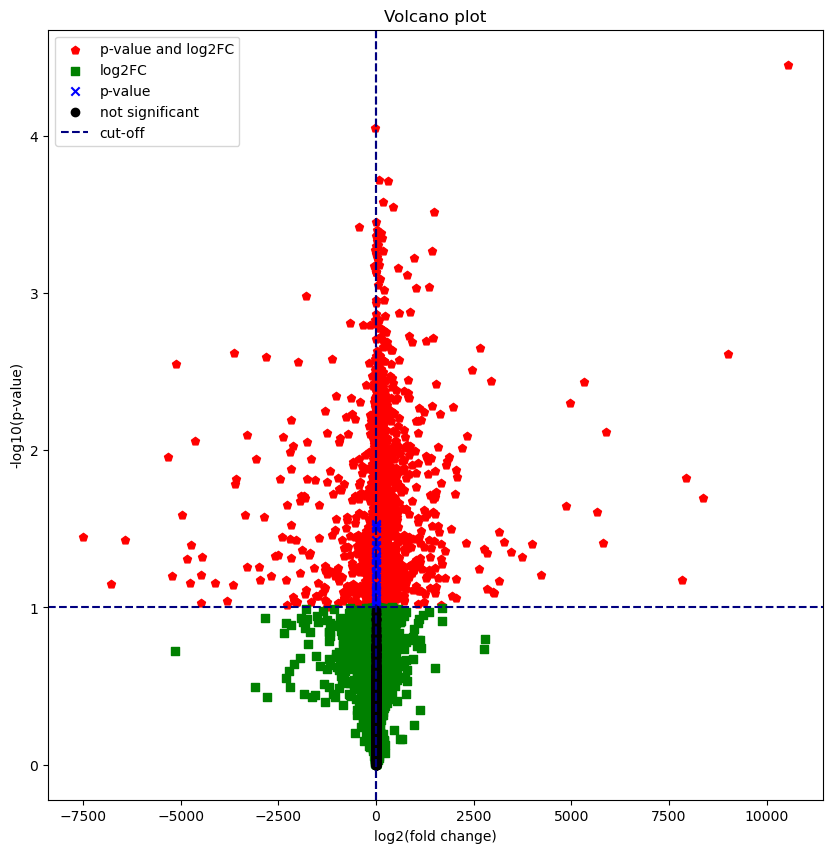

In [7]:
# Process each file in the folder
for filename in os.listdir(input_folder):
    if filename.endswith("data.txt"):
        # Load the data file
        data_path = os.path.join(input_folder, filename)
        data_df = pd.read_csv(data_path, low_memory=False, delimiter = "\t")
        
        
        ## ADD A SECTION REMOVING ROWS WHERE 1+ SAMPLES HAVE VALUE <10
        

        # establish variable for dataset name (e.g., GSEXXXXX)
        datasetname = filename.replace("data.txt", "")
        print(datasetname)
        
        output_subfolder = output_folder + "\\" + datasetname #define output folder
        if not os.path.exists(output_subfolder):
            os.mkdir(output_subfolder)        
        
        # Find the corresponding sample file
        sample_filename = filename.replace("data", "samples")
        sample_path = os.path.join(input_folder, sample_filename)

        # Ensure the sample file exists before loading
        if os.path.exists(sample_path):
            sample_df = pd.read_csv(sample_path, sep="\t", header=None)

            # Assign experimental and control columns based on sample data
            experimentalcolsarray = sample_df.iloc[0].to_numpy() == 1
            experimentalcols = np.where(experimentalcolsarray)[0].tolist()
            print("Experimental")
            for l in experimentalcols:
                print(data_df.columns[l+1]) #check this output to ensure proper column selection
            print()
            
            controlcolsarray = sample_df.iloc[0].to_numpy() == 0
            controlcols = np.where(controlcolsarray)[0].tolist()
            print("Control")
            for l in controlcols:
                print(data_df.columns[l+1]) #check this output to ensure proper column selection
            print()
                        
            #analyze data
            log10pvaldf = Tscore(data_df, experimentalcols, controlcols, output_subfolder) #call function to calculate log10pval
            dfFC = FCstat(data_df, experimentalcols, controlcols, output_subfolder) #call function to calculate log10pval
            volcano_plot(data_df, log10pvaldf, dfFC, output_subfolder) #call function to analyze and visualize volcano plot
            
        else:
            print(f"No matching sample file for {filename}")